In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
plt.style.use("fivethirtyeight")

In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [3]:
training_table = pd.read_csv("./data/occupancy_data/datatraining.txt")

In [4]:
# training_table["year"] = training_table["date"].str[:4].astype(int) # only 2015
# training_table["month"] = training_table["date"].str[5:7].astype(int) # only February
training_table["day"] = training_table["date"].str[8:10].astype(int)
training_table["hour"] = training_table["date"].str[11:13].astype(int)

training_table["Temperature"] = training_table["Temperature"].astype(np.float32)
training_table["Humidity"] = training_table["Humidity"].astype(np.float32)
training_table["Light"] = training_table["Light"].astype(np.float32)
training_table["CO2"] = training_table["CO2"].astype(np.float32)
training_table["HumidityRatio"] = training_table["HumidityRatio"].astype(np.float32)
training_table["Occupancy"] = training_table["Occupancy"].astype(np.float32)

In [5]:
training_table = training_table.drop("date", axis=1)

In [6]:
training_table.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
1,23.18,27.271999,426.0,721.25,0.004793,1.0,4,17
2,23.15,27.267500,429.5,714.00,0.004783,1.0,4,17
3,23.15,27.245001,426.0,713.50,0.004779,1.0,4,17
4,23.15,27.200001,426.0,708.25,0.004772,1.0,4,17
5,23.10,27.200001,426.0,704.50,0.004757,1.0,4,17


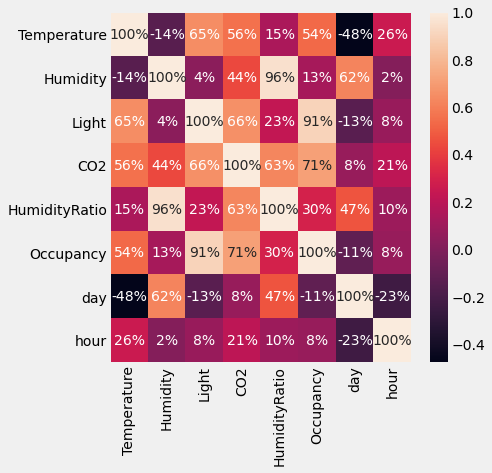

In [7]:
plt.figure(figsize=(6, 6))
sns.heatmap(training_table.corr(), annot=True, fmt=".0%")

> There seems to be little correlation between `day` and `hour` with **Occupancy**.

In [8]:
training_table = training_table.drop("day", axis=1)
training_table = training_table.drop("hour", axis=1)

In [9]:
SEQ_LEN = 50
NUM_FEAT = 5

In [10]:
scaler = RobustScaler()

In [11]:
X_train = training_table.drop("Occupancy", axis=1).values
Y_train = training_table["Occupancy"].values
X_train = scaler.fit_transform(X_train, Y_train)
training_sequence = [(X_train[i:i+SEQ_LEN, :], Y_train[i+SEQ_LEN]) for i in range(0, len(X_train) - SEQ_LEN)]
N = len(Y_train)

In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from train_utils import train_model, BCLogitMetric

In [13]:
train_set, test_set = train_test_split(training_sequence, test_size=0.3, shuffle=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True, num_workers=2)
val_dl = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=True, num_workers=2)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(NUM_FEAT, 50)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def regularizer(self):        
        return 0.
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = torch.relu(self.fc1(result))
        result = self.fc2(result).flatten()
        return result

In [15]:
net = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
metrics = [BCLogitMetric()]

In [17]:
%%time
net = train_model(net, train_dl, val_dl, criterion, optimizer, "occupancy.pt", 100, metrics=metrics, patience=5)

[1, 100.00%] train loss: 0.597367
[1, 100.00%] validate loss: 0.376645
Accuracy = 0.927
[2, 100.00%] train loss: 0.291806
[2, 100.00%] validate loss: 0.253961
Accuracy = 0.931
[3, 100.00%] train loss: 0.245157
[3, 100.00%] validate loss: 0.226765
Accuracy = 0.924
[4, 100.00%] train loss: 0.188065
[4, 100.00%] validate loss: 0.160681
Accuracy = 0.928
[5, 100.00%] train loss: 0.120644
[5, 100.00%] validate loss: 0.090322
Accuracy = 0.937
[6, 100.00%] train loss: 0.084630
[6, 100.00%] validate loss: 0.073954
Accuracy = 0.944
[7, 100.00%] train loss: 0.073512
[7, 100.00%] validate loss: 0.071653
Accuracy = 0.949
[8, 100.00%] train loss: 0.067087
[8, 100.00%] validate loss: 0.068138
Accuracy = 0.953
[9, 100.00%] train loss: 0.063011
[9, 100.00%] validate loss: 0.065038
Accuracy = 0.957
[10, 100.00%] train loss: 0.057594
[10, 100.00%] validate loss: 0.063088
Accuracy = 0.960
[11, 100.00%] train loss: 0.055517
[11, 100.00%] validate loss: 0.062140
Accuracy = 0.962
[12, 100.00%] train loss: 0.

## Test

In [18]:
test_table = pd.read_csv("./data/occupancy_data/datatest.txt")
test_table = test_table.drop("date", axis=1)
test_table = test_table.astype(np.float32)

In [19]:
X_test = test_table.drop("Occupancy", axis=1).values
X_test = scaler.transform(X_test)
X_test = np.array([X_test[i:i+SEQ_LEN, :] for i in range(0, len(X_test) - SEQ_LEN)])
X_test = X_test.swapaxes(1, 0)
Y_test = test_table["Occupancy"].values[SEQ_LEN:]
X_test = torch.tensor(X_test)

In [20]:
net.eval()
with torch.no_grad():
    outputs = net(X_test)
    outputs = torch.sigmoid(outputs)

In [21]:
roc_auc_score(Y_test, outputs)

0.9868778292138229

In [22]:
accuracy_score(Y_test, torch.round(outputs))

0.9606118546845124

In [23]:
precision_score(Y_test, torch.round(outputs))

0.9379679144385027